# Модель оптимального управления банковскими депозитами

### Импорт и подготовка данных

In [39]:
import numpy as np

In [40]:
np.version.version

'1.23.0'

В новых версиях numpy при импорте tensorflow возникает следующая ошибка:

AttributeError: module 'numpy' has no attribute 'typeDict'

Поэтому используем версию 1.21.0

In [41]:
import pandas as pd
import datetime as dt

In [42]:
#берем данные начиная с 01.10.2013 (в сентябре была введена в действие ключевая ставка ЦБ)
start_date = dt.datetime(year = 2013, month = 10, day = 1)

#обрезаем датасеты до 01.02.2023
end_date = dt.datetime(year = 2023, month = 2, day = 1)

#название месяца по его номеру
month_names = {1:'Январь', 2:'Февраль', 3:'Март', 4:'Апрель', 5:'Май', 6:'Июнь',
               7:'Июль', 8:'Август', 9:'Сентябрь', 10:'Октябрь', 11:'Ноябрь', 12:'Декабрь'}

#номер месяца по названию
month_names_to_nums = {value:key for key, value in month_names.items()}

#здесь будут сохраняться минимальные и максимальные значения по параметрам для дальнейшей нормализации
min_maxs = {}

In [43]:
#Преобразует дату в строку "Месяц Год" (например, "Сентябрь 2009"). Работает и в обратную сторону (ставится первое число месяца)
def datetime_str_transform(date = None, string = None, str_to_datetime = False):
    
    #преобразование строки в дату, если str_to_datetime = True. Иначе преобразование даты в строку
    if str_to_datetime:        
        
        #находим индекс пробела в строке (пробел - разделитель между названием месяца и года)
        sep_index = string.find(' ')
        
        #преобразуем в дату datetime
        return dt.datetime(year = int(string[sep_index + 1:]), month = month_names_to_nums[string[:sep_index]], day = 1)
        
    else:        
        return month_names[date.month] + ' ' + str(date.year)

In [44]:
#Поиск значения по любой дате в пределах датасета
#Метод только для датасетов заданной структуры: столбец с датой или месяцем идет первым, со значениями - вторым, всего их два
def value_on_date(df, date: dt.datetime, monthly = False):

    #определяем имена столбцов с датами и значениями
    date_col, value_col = df.columns[0], df.columns[1]
    
    #параметр monthly определяет, что находится в первом столбце: дата или месяц (False или True соответственно)
    if monthly:
        
        value = df[df[date_col] == datetime_str_transform(date = date)][value_col].to_numpy()[0]
        
    else:
        
        #если искомой даты нет в датасете - считаем среднее между значениями на соседние присутствующие даты
        try:

            value = df[df[date_col] == date][value_col].to_numpy()[0]

        except IndexError:

            next_value = df[df[date_col] > date].tail(1)[value_col].to_numpy()[0]
            prev_value = df[df[date_col] < date].head(1)[value_col].to_numpy()[0]
            value = (next_value + prev_value) / 2

    return value

#### Темпы роста инфляции в % в России (источник: https://www.statbureau.org/ru/russia/inflation-tables)

In [45]:
inflation = pd.read_csv('./data/inflation.csv')

#убираем пробелы из названий столбцов
old_names = inflation.columns
new_names = {old_names[i]:old_names[i].strip() for i in range(len(old_names))}
inflation.rename(columns = new_names, inplace = True)

#фильтруем по дате
inflation = inflation[(inflation.Год >= start_date.year) & (inflation.Год <= end_date.year)]

#ставим индексы с нуля
inflation.reset_index(drop = True, inplace = True)

#добавляем минимальное и максимальное значения в словарь
values = inflation[inflation.columns[1:-1]].to_numpy().flatten()
min_maxs['Темп_инфляции'] = (min(values), max(values))

inflation

,Год,Январь,Февраль,Март,Апрель,Май,Июнь,Июль,Август,Сентябрь,Октябрь,Ноябрь,Декабрь,Всего
0,2013,0.97,0.56,0.34,0.51,0.66,0.42,0.82,0.14,0.21,0.57,0.56,0.51,6.45
1,2014,0.59,0.70,1.02,0.90,0.90,0.62,0.49,0.24,0.65,0.82,1.28,2.62,11.36
2,2015,3.85,2.22,1.21,0.46,0.35,0.19,0.80,0.35,0.57,0.74,0.75,0.77,12.91
3,2016,0.96,0.63,0.46,0.44,0.41,0.36,0.54,0.01,0.17,0.43,0.44,0.40,5.38
4,2017,0.62,0.22,0.13,0.33,0.37,0.61,0.07,-0.54,-0.15,0.20,0.22,0.42,2.52
5,2018,0.31,0.21,0.29,0.38,0.38,0.49,0.27,0.01,0.16,0.35,0.50,0.84,4.27
6,2019,1.01,0.44,0.32,0.29,0.34,0.04,0.20,-0.24,-0.16,0.13,0.28,0.36,3.05
7,2020,0.40,0.33,0.55,0.83,0.27,0.22,0.35,-0.04,-0.07,0.43,0.71,0.83,4.91
8,2021,0.67,0.78,0.66,0.58,0.74,0.69,0.31,0.17,0.60,1.11,0.96,0.82,8.39
9,2022,0.99,1.17,7.61,1.56,0.12,-0.35,-0.39,-0.52,0.05,0.18,0.37,0.78,11.92


#### Ключевая ставка ЦБ (источник: https://www.cbr.ru/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=01.04.2023)

In [46]:
key_rates = pd.read_excel('./data/key_rates.xlsx', parse_dates = ['Дата'])

#фильтруем по дате
key_rates = key_rates[(key_rates.Дата >= start_date) & (key_rates.Дата <= end_date)]

#сортируем по дате по возрастанию
key_rates = key_rates.sort_values(by = 'Дата')

#ставим индексы с нуля
key_rates.reset_index(drop = True, inplace = True)

#добавляем минимальное и максимальное значения в словарь
min_maxs['Ключевая_ставка'] = (min(key_rates.Ставка), max(key_rates.Ставка))

key_rates

,Дата,Ставка
0,2013-10-01,5.5
1,2013-10-02,5.5
2,2013-10-03,5.5
3,2013-10-04,5.5
4,2013-10-07,5.5
...,...,...
2323,2023-01-26,7.5
2324,2023-01-27,7.5
2325,2023-01-30,7.5
2326,2023-01-31,7.5


#### Курс доллара к рублю (источник: http://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.so=1&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.From=13.09.2013&UniDbQuery.To=01.04.2023)

In [47]:
dollar = pd.read_excel('./data/dollar.xlsx', usecols = ['data', 'curs'])

#переименуем столбцы для удобства
dollar.rename(columns={'data': 'Дата', 'curs': 'Курс'}, inplace=True)

#фильтруем по дате
dollar = dollar[(dollar.Дата >= start_date) & (dollar.Дата <= end_date)]

#сортируем по дате по возрастанию
dollar = dollar.sort_values(by = 'Дата')

#ставим индексы с нуля
dollar.reset_index(drop = True, inplace = True)

#добавляем минимальное и максимальное значения в словарь
min_maxs['Курс_доллара'] = (min(dollar.Курс), max(dollar.Курс))

dollar

,Дата,Курс
0,2013-10-01,32.4839
1,2013-10-02,32.2965
2,2013-10-03,32.2979
3,2013-10-04,32.1250
4,2013-10-05,32.1005
...,...,...
2297,2023-01-26,68.9573
2298,2023-01-27,69.1263
2299,2023-01-28,69.3372
2300,2023-01-31,69.5927


#### Курс евро к рублю (источник: http://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.so=1&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01239&UniDbQuery.From=13.09.2013&UniDbQuery.To=01.04.2023)

In [48]:
euro = pd.read_excel('./data/euro.xlsx', usecols = ['data', 'curs'])

#переименуем столбцы для удобства
euro.rename(columns={'data': 'Дата', 'curs': 'Курс'}, inplace=True)

#фильтруем по дате
euro = euro[(euro.Дата >= start_date) & (euro.Дата <= end_date)]

#сортируем по дате по возрастанию
euro = euro.sort_values(by = 'Дата')

#ставим индексы с нуля
euro.reset_index(drop = True, inplace = True)

#добавляем минимальное и максимальное значения в словарь
min_maxs['Курс_евро'] = (min(euro.Курс), max(euro.Курс))

euro

,Дата,Курс
0,2013-10-01,43.8143
1,2013-10-02,43.8005
2,2013-10-03,43.6603
3,2013-10-04,43.6932
4,2013-10-05,43.7337
...,...,...
2297,2023-01-26,74.9564
2298,2023-01-27,75.3348
2299,2023-01-28,75.4062
2300,2023-01-31,75.7799


#### Средневзвешенные ставки по кредитам физлиц  в рублях в целом по РФ (источники: https://www.cbr.ru/vfs/statistics/pdko/int_rat/loans_ind.xlsx, https://www.cbr.ru/statistics/b_sector/rates_cr-no-r_13/)

In [49]:
loan_rates = pd.read_excel('./data/loan_rates.xlsx')

#фильтруем по дате
start_index = loan_rates.loc[loan_rates.Месяц == datetime_str_transform(date = start_date)].index[0]
end_index = loan_rates.loc[loan_rates.Месяц == datetime_str_transform(date = end_date)].index[0]
loan_rates = loan_rates.iloc[start_index:end_index + 1]

#ставим индексы с нуля
loan_rates.reset_index(drop = True, inplace = True)

#добавляем минимальные и максимальные значения в словарь
min_maxs['КрСтавка1_3'] = (min(loan_rates['от 31 до 90 дней']), max(loan_rates['от 31 до 90 дней']))
min_maxs['КрСтавка4_6'] = (min(loan_rates['от 91 до 180 дней']), max(loan_rates['от 91 до 180 дней']))
min_maxs['КрСтавка7_12'] = (min(loan_rates['от 181 дня до 1 года']), max(loan_rates['от 181 дня до 1 года']))
min_maxs['КрСтавка13_36'] = (min(loan_rates['от 1 года до 3 лет']), max(loan_rates['от 1 года до 3 лет']))

loan_rates

,Месяц,от 31 до 90 дней,от 91 до 180 дней,от 181 дня до 1 года,от 1 года до 3 лет
0,Октябрь 2013,10.40,11.00,11.00,11.70
1,Ноябрь 2013,10.50,11.00,11.30,11.50
2,Декабрь 2013,10.50,11.00,11.50,11.10
3,Январь 2014,16.09,30.39,23.81,21.69
4,Февраль 2014,15.35,23.72,22.58,20.99
...,...,...,...,...,...
108,Октябрь 2022,28.66,20.42,16.14,15.83
109,Ноябрь 2022,13.99,20.18,17.12,16.47
110,Декабрь 2022,19.02,18.92,16.63,15.94
111,Январь 2023,30.35,19.90,16.37,15.73


#### Средневзвешенные процентные ставки по депозитам физлиц в рублях в целом по РФ (источники: https://www.cbr.ru/statistics/bank_sector/int_rat/, https://www.cbr.ru/statistics/b_sector/dii_rates_2-1_13/)

In [50]:
deposit_rates = pd.read_excel('./data/deposit_rates.xlsx')

#фильтруем по дате
start_index = deposit_rates.loc[deposit_rates.Месяц == datetime_str_transform(date = start_date)].index[0]
end_index = deposit_rates.loc[deposit_rates.Месяц == datetime_str_transform(date = end_date)].index[0]
deposit_rates = deposit_rates.iloc[start_index:end_index + 1]

#ставим индексы с нуля
deposit_rates.reset_index(drop = True, inplace = True)

#добавляем минимальные и максимальные значения в словарь
min_maxs['ДепСтавка1_3'] = (min(deposit_rates['от 31 до 90 дней']), max(deposit_rates['от 31 до 90 дней']))
min_maxs['ДепСтавка4_6'] = (min(deposit_rates['от 91 до 180 дней']), max(deposit_rates['от 91 до 180 дней']))
min_maxs['ДепСтавка7_12'] = (min(deposit_rates['от 181 дня до 1 года']), max(deposit_rates['от 181 дня до 1 года']))
min_maxs['ДепСтавка13_36'] = (min(deposit_rates['от 1 года до 3 лет']), max(deposit_rates['от 1 года до 3 лет']))

deposit_rates

,Месяц,от 31 до 90 дней,от 91 до 180 дней,от 181 дня до 1 года,от 1 года до 3 лет
0,Октябрь 2013,5.20,6.00,7.00,7.60
1,Ноябрь 2013,5.00,5.90,7.10,7.40
2,Декабрь 2013,5.00,6.00,7.30,7.40
3,Январь 2014,6.32,7.03,7.56,7.98
4,Февраль 2014,6.43,7.41,8.02,7.84
...,...,...,...,...,...
108,Октябрь 2022,7.30,7.53,8.20,8.34
109,Ноябрь 2022,7.42,7.63,8.27,7.79
110,Декабрь 2022,7.23,8.07,7.87,8.47
111,Январь 2023,7.25,7.88,7.52,6.71


#### Количество действующих кредитных организаций (филиалы) в РФ (источники: https://www.cbr.ru/statistics/bank_system_new/cr_inst_branch_010101/, https://www.cbr.ru/statistics/bank_sector/lic/)

In [51]:
banks_num = pd.read_excel('./data/banks_num.xlsx')

#фильтруем по дате
start_index = banks_num.loc[banks_num.Месяц == datetime_str_transform(date = start_date)].index[0]
end_index = banks_num.loc[banks_num.Месяц == datetime_str_transform(date = end_date)].index[0]
banks_num = banks_num.iloc[start_index:end_index + 1]

#ставим индексы с нуля
banks_num.reset_index(drop = True, inplace = True)

banks_num

,Месяц,Количество
0,Октябрь 2013,2093
1,Ноябрь 2013,2067
2,Декабрь 2013,2037
3,Январь 2014,2005
4,Февраль 2014,1985
...,...,...
108,Октябрь 2022,459
109,Ноябрь 2022,461
110,Декабрь 2022,459
111,Январь 2023,449


#### Объем привлеченных кредитными организациями РФ вкладов физических лиц в млрд. руб. (источник: https://www.cbr.ru/Content/Document/File/115862/obs_tabl20c.xlsx)

***Для нас этот датасет будет показывать, какую сумму вкладов привлекала в среднем одна кредитная организация за месяц***

In [52]:
deposit_amounts = pd.read_excel('./data/deposit_amounts.xlsx')

#фильтруем по дате
start_index = deposit_amounts.loc[deposit_amounts.Месяц == datetime_str_transform(date = start_date)].index[0]
end_index = deposit_amounts.loc[deposit_amounts.Месяц == datetime_str_transform(date = end_date)].index[0]
deposit_amounts = deposit_amounts.iloc[start_index:end_index + 1]

#ставим индексы с нуля
deposit_amounts.reset_index(drop = True, inplace = True)

#делим объемы депозитов на количества организаций
deposit_amounts.Объем = deposit_amounts.Объем * 1_000_000_000 / banks_num.Количество

#добавляем минимальное и максимальное значения в словарь
min_maxs['Объем_депозитов'] = (min(deposit_amounts.Объем), max(deposit_amounts.Объем))

deposit_amounts

,Месяц,Объем
0,Октябрь 2013,2.508846e+09
1,Ноябрь 2013,2.496421e+09
2,Декабрь 2013,2.621738e+09
3,Январь 2014,2.951676e+09
4,Февраль 2014,2.799776e+09
...,...,...
108,Октябрь 2022,3.754635e+10
109,Ноябрь 2022,3.724773e+10
110,Декабрь 2022,3.925627e+10
111,Январь 2023,4.558199e+10


#### Объем выданных кредитными организациями РФ кредитов физическим лицам в млрд. руб. (источник: https://www.cbr.ru/Content/Document/File/115862/obs_tabl20c.xlsx)

***Для нас этот датасет будет показывать, какую сумму кредитов выдавала в среднем одна кредитная организация за месяц***

In [53]:
loan_amounts = pd.read_excel('./data/loan_amounts.xlsx')

#фильтруем по дате
start_index = loan_amounts.loc[loan_amounts.Месяц == datetime_str_transform(date = start_date)].index[0]
end_index = loan_amounts.loc[loan_amounts.Месяц == datetime_str_transform(date = end_date)].index[0]
loan_amounts = loan_amounts.iloc[start_index:end_index + 1]

#ставим индексы с нуля
loan_amounts.reset_index(drop = True, inplace = True)

#делим объемы кредитов на количества организаций
loan_amounts.Объем = loan_amounts.Объем * 1_000_000_000 / banks_num.Количество

#добавляем минимальное и максимальное значения в словарь
min_maxs['Объем_кредитов'] = (min(loan_amounts.Объем), max(loan_amounts.Объем))

loan_amounts

,Месяц,Объем
0,Октябрь 2013,4.372109e+09
1,Ноябрь 2013,4.531208e+09
2,Декабрь 2013,4.672806e+09
3,Январь 2014,4.847848e+09
4,Февраль 2014,4.900527e+09
...,...,...
108,Октябрь 2022,5.770731e+10
109,Ноябрь 2022,5.802277e+10
110,Декабрь 2022,5.896708e+10
111,Январь 2023,6.104590e+10


In [54]:
min_maxs

{'Темп_инфляции': (-0.54, 7.61),
 'Ключевая_ставка': (4.25, 20.0),
 'Курс_доллара': (31.6618, 120.3785),
 'Курс_евро': (43.5123, 132.9581),
 'КрСтавка1_3': (9.84, 30.35),
 'КрСтавка4_6': (11.0, 30.39),
 'КрСтавка7_12': (11.0, 33.55),
 'КрСтавка13_36': (11.1, 29.69),
 'ДепСтавка1_3': (3.76, 19.31),
 'ДепСтавка4_6': (3.99, 19.95),
 'ДепСтавка7_12': (4.14, 16.04),
 'ДепСтавка13_36': (4.12, 16.14),
 'Объем_депозитов': (2496421238.5099177, 45581985298.44098),
 'Объем_кредитов': (4372109257.0473, 61481732430.80357)}

### Построение моделей для прогноза дневных объемов депозитов и кредитов

In [55]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score
import pickle

In [56]:
import warnings
warnings.filterwarnings('ignore')

In [57]:
MODEL_SAVE_DIR = './saved_models/' #в эту папку будут сохраняться обученные модели

**Вспомогательные функции**

In [58]:
#Возвращает массив с нормализованными данными одного параметра (min-max)
def normalize_x(arr, min_max):   
    return np.array([(x - min_max[0]) / (min_max[1] - min_max[0]) for x in arr], dtype = 'float32')

In [59]:
#возвращает исходное значение параметра по нормализованному
def denormalize_x(norm_x, min_max):
    return (min_max[1] - min_max[0]) * norm_x + min_max[0]

In [60]:
#Специальный метод для датасетов со ставками на депозиты и кредиты. Возвращает массив из четырех ставок на указанный месяц
def rates_on_month(df, string):
    return df[df.Месяц == string][df.columns[1:]].to_numpy().flatten()

**Подготовка данных для обучения моделей**

In [61]:
#Метод разделяет датасет на тренировочные и тестовые данные (train_samples_percentage - доля обучающей выборки в датасете)
#Возвращает нормализованные выборки, а также словарь с минимальными и максимальными значениями обучающей выборки
def get_train_test(df, train_samples_percentage: float):
    
    #кол-во элементов в обучающей и тестовой выборках
    train_samples_num = round(len(common_ds) * train_samples_percentage)
    test_samples_num = len(common_ds) - train_samples_num

    #формирование выборок
    train_ds = df.head(train_samples_num)
    test_ds = df.head(test_samples_num)

    #нормализуем выборки
    for column in common_ds.columns[1:]:

        train_ds[column] = normalize_x(train_ds[column], min_maxs[column])
        test_ds[column] = normalize_x(test_ds[column], min_maxs[column])
        
    #преобразуем входные параметры и значения целевой функции в массивы numpy правильных размерностей
    y_train = train_ds[train_ds.columns[1:2]].to_numpy().flatten()
    y_test = test_ds[test_ds.columns[1:2]].to_numpy().flatten()

    X_train = train_ds[train_ds.columns[2:]].to_numpy()
    X_test = test_ds[test_ds.columns[2:]].to_numpy()
    
    return X_train, y_train, X_test, y_test

In [62]:
#создаем словарь для данных общего датасета
columns = ['Месяц', 'Объем_депозитов', 'Темп_инфляции', 'Ключевая_ставка', 'Курс_доллара', 'Курс_евро',
           'ДепСтавка1_3', 'ДепСтавка4_6', 'ДепСтавка7_12', 'ДепСтавка13_36']

data = {column:[] for column in columns}

#заполняем данные данные по первым числам каждого месяца с начальной по конечную дату включительно (берем месяца из banks_num)
for string in banks_num.Месяц:
    
    #получаем дату из строки "Месяц Год" с помощью заранее заданного метода datetime_str_transform()
    date = datetime_str_transform(string = string, str_to_datetime = True)
    
    #добавляем месяц в список месяцев
    data['Месяц'].append(string)
        
    #здесь работает метод value_on_date()
    data['Объем_депозитов'].append(value_on_date(deposit_amounts, date, monthly = True))
    data['Ключевая_ставка'].append(value_on_date(key_rates, date))
    data['Курс_доллара'].append(value_on_date(dollar, date))
    data['Курс_евро'].append(value_on_date(euro, date))
    
    #здесь он не работает
    data['Темп_инфляции'].append(inflation[inflation.Год == date.year][month_names[date.month]].to_numpy()[0])
    
    #получаем массив ставок по депозитам на рассматриваемый месяц и расставляем по спискам
    deposit_rates_on_month = rates_on_month(deposit_rates, string)
    
    data['ДепСтавка1_3'].append(deposit_rates_on_month[0])
    data['ДепСтавка4_6'].append(deposit_rates_on_month[1])
    data['ДепСтавка7_12'].append(deposit_rates_on_month[2])
    data['ДепСтавка13_36'].append(deposit_rates_on_month[3])

#конвертация в датафрейм
common_ds = pd.DataFrame(data)
common_ds

,Месяц,Объем_депозитов,Темп_инфляции,Ключевая_ставка,Курс_доллара,Курс_евро,ДепСтавка1_3,ДепСтавка4_6,ДепСтавка7_12,ДепСтавка13_36
0,Октябрь 2013,2.508846e+09,0.57,5.5,32.48390,43.81430,5.20,6.00,7.00,7.60
1,Ноябрь 2013,2.496421e+09,0.56,5.5,32.07580,43.94060,5.00,5.90,7.10,7.40
2,Декабрь 2013,2.621738e+09,0.51,6.5,51.50065,60.05735,5.00,6.00,7.30,7.40
3,Январь 2014,2.951676e+09,0.59,6.5,32.65870,45.05590,6.32,7.03,7.56,7.98
4,Февраль 2014,2.799776e+09,0.70,6.5,35.18000,47.64080,6.43,7.41,8.02,7.84
...,...,...,...,...,...,...,...,...,...,...
108,Октябрь 2022,3.754635e+10,0.18,6.5,55.29870,52.73790,7.30,7.53,8.20,8.34
109,Ноябрь 2022,3.724773e+10,0.37,7.5,61.62290,61.11960,7.42,7.63,8.27,7.79
110,Декабрь 2022,3.925627e+10,0.78,7.5,60.88030,63.05040,7.23,8.07,7.87,8.47
111,Январь 2023,4.558199e+10,0.84,6.5,51.50065,60.05735,7.25,7.88,7.52,6.71


In [63]:
#разделяем датасет на выборки с помощью заранее заданного метода get_train_test()
X_train, y_train, X_test, y_test = get_train_test(common_ds, 0.5)

**Создание и обучение модели для прогноза дневных объемов привлечений**

In [64]:
#Обучает модель регрессии гауссовского процесса
def train_and_save_model(model_name: str, X_train, y_train):
    
    print('Начат процесс обучения...')
    
    #задаем ядро и создаем модель регрессии гауссовского процесса
    kernel = RBF() + WhiteKernel()
    model = GaussianProcessRegressor(kernel)

    #обучаем модель на тренировочных данных
    model.fit(X_train, y_train)
    
    #сохраняем обученную модель в файл
    pickle.dump(model, open(MODEL_SAVE_DIR + model_name + '.sav', 'wb'))
    print('Модель успешно обучена и сохранена!')
    
    return model

In [65]:
#Возвращает обученную модель (загрузка из файла или обучение на переданных данных)
def get_trained_model(model_name: str, X_train, y_train, train_new = False):
    
    #модель обучается в двух случаях: если train_new = True или если не был найден файл с сохраненной моделью
    if train_new:      
        model = train_and_save_model(model_name, X_train, y_train)
    
    else:
        
        try:            
            model = pickle.load(open(MODEL_SAVE_DIR + model_name + '.sav', 'rb'))
            print('Модель успешно загружена!')

        except FileNotFoundError:           
            print('Не удалось загрузить модель, файл не найден')
            model = train_and_save_model(model_name, X_train, y_train)


    return model

In [66]:
#Выводит на экран значения метрик для оценки точности модели на обучающей и тестовой выборках
def evaluate_model(model, X_train, y_train, X_test, y_test):
    
    #прогнозируем значения целевой функции на обеих выборках
    y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)
    
    print(f'На обучающей выборке:\n'
          f'R2_score: {r2_score(y_train, y_pred_train)}\n'
          f'MSE: {mse(y_train, y_pred_train)}\n'
          f'MAE: {mae(y_train, y_pred_train)}\n\n'
          f'На тестовой выборке:\n'
          f'R2_score: {r2_score(y_test, y_pred_test)}\n'
          f'MSE: {mse(y_test, y_pred_test)}\n'
          f'MAE: {mae(y_test, y_pred_test)}'
         )

In [67]:
#получаем обученную модель
deposit_predictor = get_trained_model('deposit_predictor', X_train, y_train)

Модель успешно загружена!


In [68]:
#оценим точность модели заранее заданным методом evaluate_model()
evaluate_model(deposit_predictor, X_train, y_train, X_test, y_test)

На обучающей выборке:
R2_score: 0.9137118275469964
MSE: 0.00024793037654773304
MAE: 0.012068730546033126

На тестовой выборке:
R2_score: 0.919387566894247
MSE: 0.00024422878637923856
MAE: 0.011963626622750263


**Создание модели для прогноза дневных объемов кредитов**

In [69]:
#переименовываем столбцы созданного ранее датасета и подставляем кредитные данные
common_ds.rename(columns = {'Объем_депозитов':'Объем_кредитов', 'ДепСтавка1_3':'КрСтавка1_3', 'ДепСтавка4_6':'КрСтавка4_6', 
                            'ДепСтавка7_12':'КрСтавка7_12', 'ДепСтавка13_36':'КрСтавка13_36'}, inplace = True)

common_ds.Объем_кредитов = loan_amounts.Объем

columns = ['КрСтавка1_3', 'КрСтавка4_6', 'КрСтавка7_12', 'КрСтавка13_36']
data = {column:[] for column in columns}

for string in common_ds.Месяц:

    loan_rates_on_month = rates_on_month(loan_rates, string)
    
    data['КрСтавка1_3'].append(loan_rates_on_month[0])
    data['КрСтавка4_6'].append(loan_rates_on_month[1])
    data['КрСтавка7_12'].append(loan_rates_on_month[2])
    data['КрСтавка13_36'].append(loan_rates_on_month[3])
    
for column in columns:    
    common_ds[column] = data[column]
    
common_ds

,Месяц,Объем_кредитов,Темп_инфляции,Ключевая_ставка,Курс_доллара,Курс_евро,КрСтавка1_3,КрСтавка4_6,КрСтавка7_12,КрСтавка13_36
0,Октябрь 2013,4.372109e+09,0.57,5.5,32.48390,43.81430,10.40,11.00,11.00,11.70
1,Ноябрь 2013,4.531208e+09,0.56,5.5,32.07580,43.94060,10.50,11.00,11.30,11.50
2,Декабрь 2013,4.672806e+09,0.51,6.5,51.50065,60.05735,10.50,11.00,11.50,11.10
3,Январь 2014,4.847848e+09,0.59,6.5,32.65870,45.05590,16.09,30.39,23.81,21.69
4,Февраль 2014,4.900527e+09,0.70,6.5,35.18000,47.64080,15.35,23.72,22.58,20.99
...,...,...,...,...,...,...,...,...,...,...
108,Октябрь 2022,5.770731e+10,0.18,6.5,55.29870,52.73790,28.66,20.42,16.14,15.83
109,Ноябрь 2022,5.802277e+10,0.37,7.5,61.62290,61.11960,13.99,20.18,17.12,16.47
110,Декабрь 2022,5.896708e+10,0.78,7.5,60.88030,63.05040,19.02,18.92,16.63,15.94
111,Январь 2023,6.104590e+10,0.84,6.5,51.50065,60.05735,30.35,19.90,16.37,15.73


In [70]:
#разделяем датасет на выборки с помощью заранее заданного метода get_train_test()
X_train, y_train, X_test, y_test = get_train_test(common_ds, 0.5)

In [71]:
#получаем обученную модель
loan_predictor = get_trained_model('loan_predictor', X_train, y_train)

Не удалось загрузить модель, файл не найден
Начат процесс обучения...
Модель успешно обучена и сохранена!


In [72]:
#оценим точность модели заранее заданным методом evaluate_model()
evaluate_model(loan_predictor, X_train, y_train, X_test, y_test)

На обучающей выборке:
R2_score: 0.9835549445936422
MSE: 4.266651989536312e-05
MAE: 0.0047952289553521155

На тестовой выборке:
R2_score: 0.9747517743427215
MSE: 7.160987396485631e-05
MAE: 0.00543284331940728


### Создание симуляционной среды и генерация портфелей

In [73]:
import random
from dateutil.relativedelta import relativedelta

**Вспомогательные функции**

In [74]:
#количество дней в каждом месяце
days_in_month = {1:31, 2:28, 3:31, 4:30, 5:31, 6:31, 7:30, 8:31, 9:30, 10:31, 11:30, 12:31}

In [75]:
#Функция возвращает тип срока, к которому относится срок term
def term_category(term):
    
    categories = ((1, 3), (4, 6), (7, 12), (13, 36))
    
    for i in range(len(categories)):
        
        if categories[i][0] <= term <= categories[i][1]:
            break
            
    return i

In [76]:
#Даты первых платежей
def first_payment_dates(df):
    
    dates = df.Дата
    payment_days = df.День_платежа

    return [dt.datetime(year = dates[i].year,
                        month = dates[i].month,
                        day = payment_days[i]) + relativedelta(months = 1) for i in range(len(df))]


#Даты последних платежей, они же даты закрытия (этот метод будет использоваться и на других этапах работы)
def close_dates(df):
    
    first_payment_dates_ = first_payment_dates(df)
    terms = df.Срок
    
    return np.array([first_payment_dates_[i] + relativedelta(months = terms[i] - 1) for i in range(len(df))])

**Класс среды**

In [77]:
#Возвращает объем потока платежей по депозитам на текущую дату
def deposit_turnover(self):
    
    #берем только депозиты, у которых текущая дата является датой закрытия, и считаем сумму обязательств по формуле сложного %
    current_deposits = self.deposits[close_dates(self.deposits) == env.date]
    turnover = sum((current_deposits.Сумма * ((current_deposits.Ставка / 100 / 12 + 1) ** current_deposits.Срок)))
    
    return turnover

#Возвращает объем потока платежей по депозитам на текущую дату
def loan_turnover(self):
    
    #берем только кредиты, у которых на текущую дату день платежа, и считаем сумму ежемесячных платежей по формуле сложного %
    current_loans = self.loans[self.loans.День_платежа == env.date.day]
    turnover = sum(current_loans.Сумма * ((current_loans.Ставка / 100 / 12 + 1) ** current_loans.Срок) / current_loans.Срок)
    
    return turnover

In [78]:
class Env: 
    
    #Конструктор класса. Задается датой, диапазоном суммы элемента портфеля, структурой портфелей и прогнозными моделями
    def __init__(self, date: dt.datetime, min_V, max_V, deposits, loans, deposit_predictor, loan_predictor):
        
        #текущая и предыдущая дата
        self.date = date
        self.prev_date = date - dt.timedelta(days = 1)
        
        #ключи для получения минимальных и максимальных значений параметров среды и ставок (совпадают по индексам)
        self.deposit_mm_keys = [key for key in list(min_maxs.keys())[:4]]
        self.deposit_mm_keys.extend([key for key in list(min_maxs.keys())[8:12]])
        self.loan_mm_keys = [key for key in list(min_maxs.keys())[:4]]
        self.loan_mm_keys.extend([key for key in list(min_maxs.keys())[4:8]])
        
        #параметры среды из датасетов
        self.key_rate = value_on_date(key_rates, date)
        self.dollar = value_on_date(dollar, date)
        self.euro = value_on_date(euro, date)
        self.inflation = inflation[inflation.Год == date.year][month_names[date.month]].to_numpy()[0]
        self.deposit_rates = rates_on_month(deposit_rates, datetime_str_transform(date))
        self.loan_rates = rates_on_month(loan_rates, datetime_str_transform(date))
        
        #минимальное и максимальное значение суммы одного депозита или кредита
        self.min_V, self.max_V = min_V, max_V
        
        #текущая структура портфелей депозитов и кредитов
        self.deposits = deposits
        self.loans = loans
        
        #модели, отражающие зависимость дневных объемов привлечений и кредитов в зависимости от ставок и параметров среды
        self.deposit_predictor = deposit_predictor
        self.loan_predictor = loan_predictor
        
        #текущее значение Q-функции и награда
        self.Q = 0
        self.reward = 0
    
    
    #Возвращает вектор параметров среды (удобно использовать для быстрого формирования входных параметров моделей)
    def get_state(self):        
        return [self.inflation, self.key_rate, self.dollar, self.euro]


    #Возвращает ожидаемые дневные объемы депозитов и кредитов по выбранной стратегии (новые ставки по депозитам)
    def predict_V(self, action):
        
        #формируем входные ветора для прогнозных моделей (для кредитов всегда применяются средневзвешенные ставки)
        deposit_params, loan_params = self.get_state(), self.get_state()
        deposit_params.extend(action)
        loan_params.extend(self.loan_rates)
        
        #нормализуем входные вектора
        deposit_params = [[normalize_x([deposit_params[i]], 
                                       min_maxs[self.deposit_mm_keys[i]])[0] for i in range(len(deposit_params))]]
        
        loan_params = [[normalize_x([loan_params[i]], min_maxs[self.loan_mm_keys[i]])[0] for i in range(len(loan_params))]]
        

        #получаем прогнозы из моделей, денормализуем и делим их на кол-во дней в месяце, получая ожидаемые дневные объемы
        deposit_V = denormalize_x(self.deposit_predictor.predict(deposit_params)[0],
                                  min_maxs['Объем_депозитов']) / days_in_month[self.date.month]
        
        loan_V = denormalize_x(self.loan_predictor.predict(loan_params)[0],
                               min_maxs['Объем_кредитов']) / days_in_month[self.date.month]

        return deposit_V, loan_V


    #Генерирует данные для одного случайного депозита или кредита на указанную дату date
    def random_item(self, date, amount, rates, payment_day):

        #ставка берется по сроку в соответствии с текущими ставками rates
        term = np.random.randint(1, 37)
        rate = rates[term_category(term)]    

        return date, amount, rate, term, payment_day


    #Генерирует обновление для портфеля (случайное число элементов общей суммой в required_V +- self.min_V)
    def update_portfolio(self, rates, required_V):
        
        #payment_day - число, на которое каждый месяц будет совершаться платеж по кредиту либо день даты закрытия депозита
        payment_day = min(self.date.day, 28)
        columns = self.deposits.columns

        items = {column:[] for column in columns}
        items_V = 0

        while items_V < required_V:

            #сумма нового элемента портфеля генерируется в пределах диапазона [self.min_V, self.max_V] и кратна 100 000
            amount = round(np.random.randint(self.min_V, self.max_V), -5)

            #если добавление amount к общей сумме превысит нужный объем портфеля
            if (items_V + amount) > required_V:

                #если разность между нужной суммой и общей больше минимальной суммы элемента, то amount равняется этой разности
                if required_V - items_V > self.min_V:
                    amount = round(required_V - items_V, -5)

                #иначе в соответствии со случайной вероятностью либо берется минимальная сумма, либо генерация заканчивается
                else:

                    if random.getrandbits(1):
                        amount = self.min_V
                    else:
                        break

            #генерируем данные для нового элемента портфеля
            new_item_data = self.random_item(self.date, amount, rates, payment_day)

            #передаем данные в словарь
            for i in range(len(columns)):
                items[columns[i]].append(new_item_data[i])

            #прибавляем значение суммы к значению общей суммы
            items_V += new_item_data[1]

        return pd.DataFrame(data = items)
    
    
    #Возвращает объем потока платежей по депозитам на текущую дату (по формуле сложного процента)
    def deposit_turnover(self):

        #берем только депозиты, у которых текущая дата является датой закрытия, и считаем сумму обязательств
        current_deposits = self.deposits[close_dates(self.deposits) == env.date]
        turnover = sum((current_deposits.Сумма * ((current_deposits.Ставка / 100 / 12 + 1) ** current_deposits.Срок)))

        return turnover


    #Возвращает объем потока платежей по депозитам на текущую дату (по формуле сложного процента)
    def loan_turnover(self):

        #берем только кредиты, у которых на текущую дату день платежа, и считаем сумму ежемесячных платежей
        current_loans = self.loans[self.loans.День_платежа == env.date.day]
        turnover = sum(current_loans.Сумма * ((current_loans.Ставка / 100 / 12 + 1) ** current_loans.Срок) / current_loans.Срок)

        return turnover


    #Метод для обновления состояния среды. На входе новые ставки по депозитам (выбранная стратегия на данный момент)
    def update_state(self, action):
        
        #устанавливаем новые ставки на депозиты
        self.deposit_rates = action
        
        #переключаем текущую дату на день вперед, обновляем значение предыдущей даты
        self.prev_date = self.date
        self.date += dt.timedelta(days = 1)
        
        #обновляем параметры среды
        self.key_rate = value_on_date(key_rates, self.date)
        self.dollar = value_on_date(dollar, self.date)
        self.euro = value_on_date(euro, self.date)
        
        #эти параметры обновляются раз в месяц (на первое число каждого месяца)
        if self.prev_date.month != self.date.month:
            self.inflation = inflation[inflation.Год == self.date.year][month_names[self.date.month]].to_numpy()[0]
            self.loan_rates = rates_on_month(loan_rates, datetime_str_transform(self.date))
        
        #прогнозируем объем привлечений и кредитов на грядущий день
        deposit_V, loan_V = self.predict_V(action)
        
        #обновляем портфели
        self.deposits = self.deposits.append(self.update_portfolio(action, deposit_V))
        self.loans = self.loans.append(self.update_portfolio(self.loan_rates, loan_V))        
        self.deposits.reset_index(drop = True, inplace = True)
        self.loans.reset_index(drop = True, inplace = True)
        
        #отбрасываем депозиты и кредиты, даты закрытия которых раньше новой даты
        self.deposits = self.deposits[close_dates(self.deposits) >= self.date]
        self.loans = self.loans[close_dates(self.loans) >= self.date]
        self.deposits.reset_index(drop = True, inplace = True)
        self.loans.reset_index(drop = True, inplace = True)
        
        #обновляем значения награды и Q-функции
        prev_Q = self.Q
        self.Q = sum(self.loans.Сумма * (self.loans.Ставка / 100 / 12 + 1) ** self.loans.Срок) - \
                 sum(self.deposits.Сумма * (self.deposits.Ставка / 100 / 12 + 1) ** self.deposits.Срок)
        self.reward = self.Q - prev_Q
        

    #Вывод данных по текущим параметрам среды
    def summary(self):
        
        print(f'Текущая дата: {self.date:%d.%m.%Y}\n\n'
              f'Темп инфляции: {self.inflation}%\n'
              f'Ключевая ставка ЦБ: {self.key_rate}%\n'
              f'Курс доллара: {round(self.dollar, 2)} руб.\n'
              f'Курс евро: {round(self.euro, 2)} руб.\n\n'
              f'Средневзвешенные ставки по кредитам в РФ:\n'
              f'от 31 до 90 дней: {self.loan_rates[0]}\n'
              f'от 91 до 180 дней: {self.loan_rates[1]}\n'
              f'от 181 дня до 1 года: {self.loan_rates[2]}\n'
              f'от 1 года до 3 лет: {self.loan_rates[3]}'
             )

**Создание среды и генерация портфелей**

In [79]:
#начинаем с этой даты
start_date = dt.datetime(year = 2013, month = 10, day = 1)

#создаем параметры для передачи в конструктор класса среды
columns = ['Дата', 'Сумма', 'Ставка', 'Срок', 'День_платежа']
deposits, loans = pd.DataFrame(columns = columns), pd.DataFrame(columns = columns)
min_V, max_V = 100_000, 100_000_000

#создание среды
env = Env(start_date, min_V, max_V, deposits, loans, deposit_predictor, loan_predictor)

In [80]:
env.summary()

Текущая дата: 01.10.2013

Темп инфляции: 0.57%
Ключевая ставка ЦБ: 5.5%
Курс доллара: 32.48 руб.
Курс евро: 43.81 руб.

Средневзвешенные ставки по кредитам в РФ:
от 31 до 90 дней: 10.4
от 91 до 180 дней: 11.0
от 181 дня до 1 года: 11.0
от 1 года до 3 лет: 11.7


In [81]:
#остановимся на этой дате
stop_date = dt.datetime(year = 2015, month = 1, day = 1)

while env.date < stop_date:
    
    action = rates_on_month(deposit_rates, datetime_str_transform(env.date))
    env.update_state(action)

In [82]:
env.deposits

,Дата,Сумма,Ставка,Срок,День_платежа
0,2013-10-02,33100000.0,7.60,23,2
1,2013-10-02,5600000.0,7.60,24,2
2,2013-10-02,34000000.0,7.60,26,2
3,2013-10-03,86000000.0,7.60,26,3
4,2013-10-04,21300000.0,7.60,35,4
...,...,...,...,...,...
1203,2015-01-01,24600000.0,12.81,35,1
1204,2015-01-01,38100000.0,15.67,10,1
1205,2015-01-01,54200000.0,12.81,29,1
1206,2015-01-01,14000000.0,15.67,9,1


In [83]:
env.loans

,Дата,Сумма,Ставка,Срок,День_платежа
0,2013-10-02,94500000.0,11.70,21,2
1,2013-10-02,24700000.0,11.70,16,2
2,2013-10-02,100000.0,11.70,16,2
3,2013-10-03,65700000.0,11.70,36,3
4,2013-10-03,42600000.0,11.70,15,3
...,...,...,...,...,...
1669,2015-01-01,67300000.0,27.00,5,1
1670,2015-01-01,1800000.0,29.69,17,1
1671,2015-01-01,78400000.0,29.69,24,1
1672,2015-01-01,11800000.0,29.69,29,1


In [84]:
env.Q, env.reward

(46732970990.03716, 154916925.89879608)

### Гэп ликвидности

In [85]:
import matplotlib.pyplot as plt
from copy import deepcopy

In [86]:
#def today_gap

In [87]:
#Прогноз структурного гэпа ликвидности на term дней вперед (строится по средневзвешенным ставкам)
def gap_forecast(env, term):
    
    #делаем копию среды
    forecast_env = deepcopy(env)
    
    #массивы для хранения прогнозных данных
    assets, liabilities, gaps = [], [], []
    
    for _ in range(term + 1):
    
        #считаем объемы депозитов и кредитов с учетом ставок и сроков
        deposit_V = sum(forecast_env.deposits.Сумма * 
                        (forecast_env.deposits.Ставка / 100 / 12 * forecast_env.deposits.Срок + 1))
        loan_V = sum(forecast_env.loans.Сумма * (forecast_env.loans.Ставка / 100 / 12 * forecast_env.loans.Срок + 1))
        
        #записываем данные в массивы
        assets.append(loan_V)
        liabilities.append(deposit_V)
        gaps.append(loan_V - deposit_V)
        
        #обновляем состояние копии среды
        forecast_env.update_state(rates_on_month(deposit_rates, datetime_str_transform(forecast_env.date)))
        
    return assets, liabilities, gaps

**Построение графиков (прогноз на 14 дней вперед)**

In [88]:
term = 14
date = env.date
end_date = date + dt.timedelta(days = term)

In [89]:
forecast_assets, forecast_liabilities, forecast_gaps = gap_forecast(env, term)

In [90]:
forecast_assets = np.array(forecast_assets) / 10**9
forecast_liabilities = np.array(forecast_liabilities) / 10**9
forecast_gaps = np.array(forecast_gaps) / 10**9

In [91]:
dates = []

for _ in range(term + 1):
    
    dates.append(f'{str(date.day).zfill(2)}.{str(date.month).zfill(2)}.{date.year}')
    date += dt.timedelta(days = 1)

In [92]:
#получение реальных данных
real_assets, real_liabilities, real_gaps = [], [], []

while env.date <= end_date:
    
    deposit_V = sum(env.deposits.Сумма * (env.deposits.Ставка / 100 / 12 * env.deposits.Срок + 1))
    loan_V = sum(env.loans.Сумма * (env.loans.Ставка / 100 / 12 * env.loans.Срок + 1))
    
    real_assets.append(loan_V)
    real_liabilities.append(deposit_V)
    real_gaps.append(loan_V - deposit_V)
    
    env.update_state(rates_on_month(deposit_rates, datetime_str_transform(env.date)))

In [93]:
real_assets = np.array(real_assets) / 10**9
real_liabilities = np.array(real_liabilities) / 10**9
real_gaps = np.array(real_gaps) / 10**9

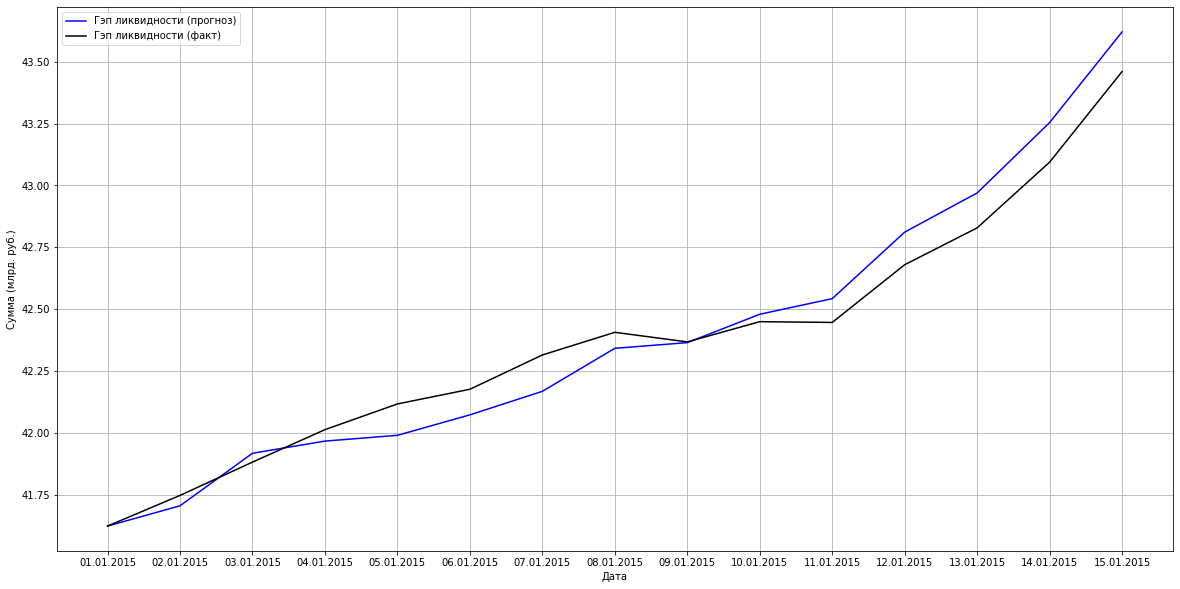

In [94]:
#График гэпа
fig, ax = plt.subplots(figsize = (20, 10))
xs = np.arange(len(dates))

ax.plot(xs, forecast_gaps, color='blue', linewidth = 1.5, label = 'Гэп ликвидности (прогноз)')
ax.plot(xs, real_gaps, color='black', linewidth = 1.5, label = 'Гэп ликвидности (факт)')

ax.grid()
ax.set_ylabel('Сумма (млрд. руб.)')
ax.set_xlabel('Дата')    
plt.xticks(xs, dates)

ax.legend()

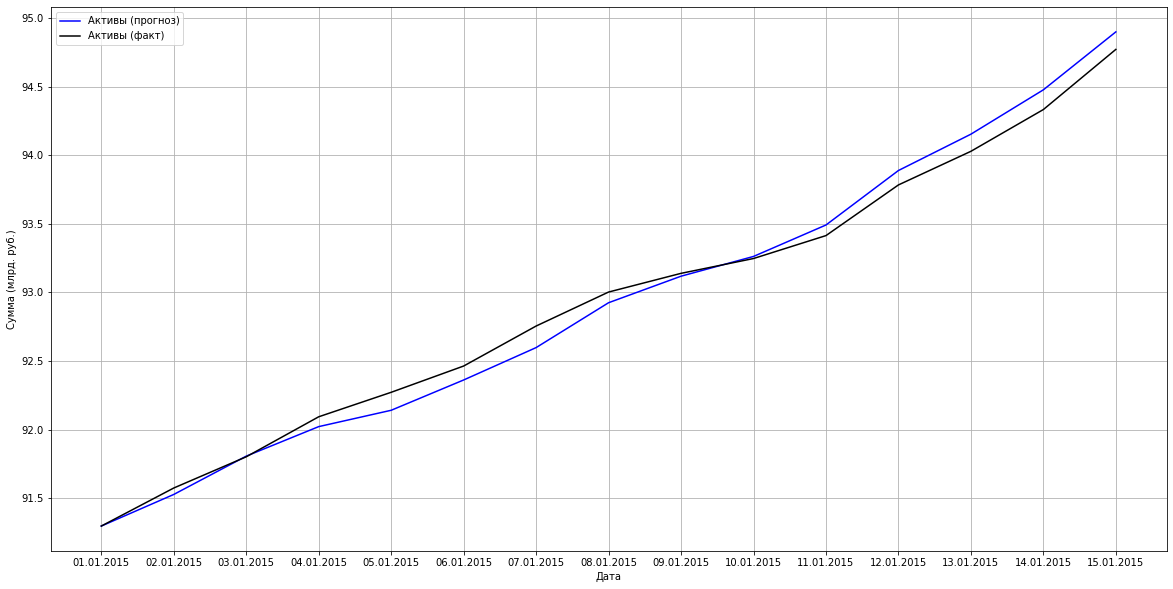

In [95]:
#График активов
fig, ax = plt.subplots(figsize = (20, 10))

ax.plot(xs, forecast_assets, color='blue', linewidth = 1.5, label = 'Активы (прогноз)')
ax.plot(xs, real_assets, color='black', linewidth = 1.5, label = 'Активы (факт)')

ax.grid()
ax.set_ylabel('Сумма (млрд. руб.)')
ax.set_xlabel('Дата')    
plt.xticks(xs, dates)

ax.legend()

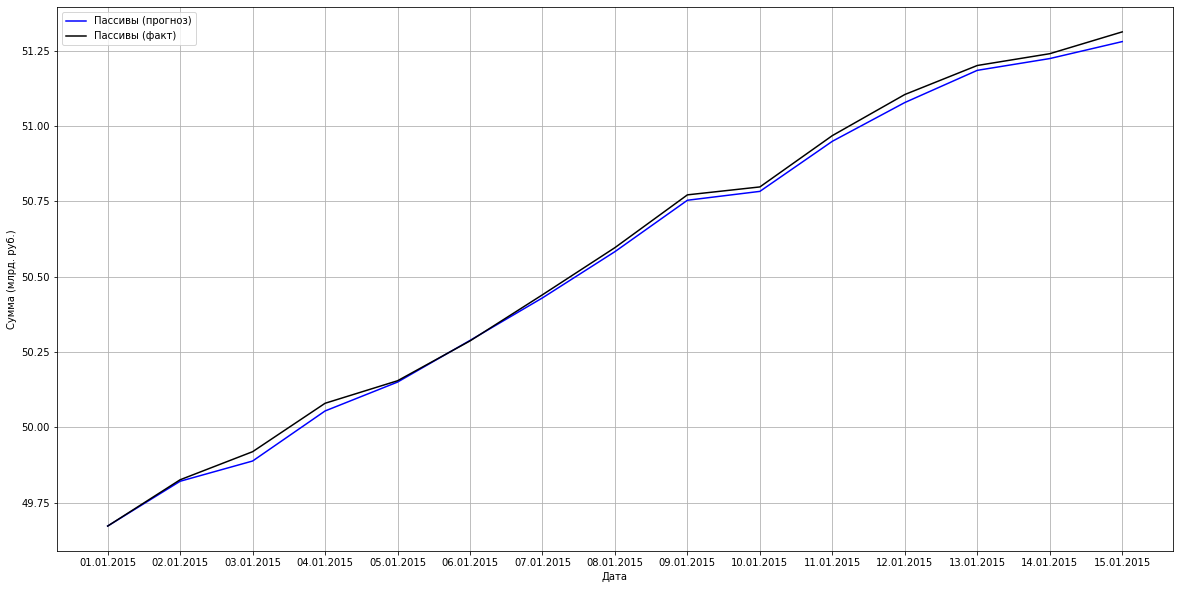

In [96]:
#График пассивов
fig, ax = plt.subplots(figsize = (20, 10))

ax.plot(xs, forecast_liabilities, color='blue', linewidth = 1.5, label = 'Пассивы (прогноз)')
ax.plot(xs, real_liabilities, color='black', linewidth = 1.5, label = 'Пассивы (факт)')

ax.grid()
ax.set_ylabel('Сумма (млрд. руб.)')
ax.set_xlabel('Дата')    
plt.xticks(xs, dates)

ax.legend()

## Создание и обучение Q-сети

In [97]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate
from tensorflow.keras.optimizers import Adam

2023-06-10 14:23:34.390541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 14:23:34.477659: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-10 14:23:34.479951: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-10 14:23:34.479960: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

#### Параметры обучения

In [98]:
#период обучения в днях
train_period = ((env.date + relativedelta(months = 2)) - env.date).days

#кол-во эпизодов обучения и размер батча
n_episodes = 1
batch_size = 8

#скорость обучения 1e-4
learning_rate = 0.001

#процедура идентификации: ε-greedy с убыванием до ε=0.001 в течение 1000 эпизодов
epsilon_decay_periods = 1000
epsilon_start = 1.000
epsilon_end = 0.001

#количество нейронов в слоях, из которых будет сложен входной слой сети
rnn_size = 4
dense_size = 4

#количество нейронов выходного слоя (равняется количеству возможных действий)
possible_actions = [round(i, 1) for i in np.arange(-1.0, 1.1, 0.1)]
output_size = len(possible_actions)

#коэффициент дисконтирования
gamma = 0.95

#диапазон, в пределах которого в процедуре ε-greedy будут генерироваться случайные ставки (крайние значения умножены на 10)
min_rate, max_rate = 40, 150

#### Создание нейросети

In [103]:
#два входных слоя: LSTM для гэпа и параметров среды, Dense - для структуры депозитных ставок
lstm_input = LSTM(rnn_size)(Input(shape = (1, rnn_size)))
dense_input = Dense(dense_size)(Input(shape = (dense_size)))

#формируем выходной слой
input_layer = concatenate([lstm_input, dense_input])
output_layer = Dense(output_size, name = 'output_layer')(input_layer)

#создаем модель
model = Model(inputs = {'LSTM':lstm_input, 'Dense':dense_input}, outputs = output_layer)
model.compile(optimizer = Adam(learning_rate = learning_rate), loss = 'mse', metrics = ['mae'])

#### Цикл обучения

In [104]:
#Функция для подготовки входных данных
def input_data(env):
    
    #данные для входного слоя LSTM
    lstm_input_data = env.get_state()
    lstm_input_data = np.array(lstm_input_data).reshape((1, rnn_size))
                
    #данные для входного слоя Dense
    dense_input_data = env.deposit_rates
    dense_input_data = np.array(dense_input_data).reshape((1, dense_size))
                
    return lstm_input_data, dense_input_data

In [105]:
#копируем исходное состояние среды
env_start_state = deepcopy(env)

In [106]:
#Цикл обучения
for episode in range(n_episodes):
    
    #устанавливаем исходное состояние среды
    env = deepcopy(env_start_state)
    
    #сброс накопленной погрешности сети
    loss = 0
    
    batch_num = 0
    
    #итерация по батчам
    for batch in range(0, train_period, batch_size):
        
        batch_num += 1
        
        #массивы для хранения совершенных действий, получившихся Q-значений и состояний среды (вместе с гэпом)
        a_list, target_list, state_list = [], [], []
        
        #обновление показателя ε в процедуре идентификации
        epsilon = epsilon_start + (epsilon_end - epsilon_start) * min((batch // batch_size + 1) / epsilon_decay_periods, 1)
        
        #итерация по наблюдениям в батче
        for _ in range(batch_size):
    
            #пользуемся функцией для формирования входных данных
            lstm_input_data, dense_input_data = input_data(env)
                
            #вычисляем целевые Q-значения с помощью текущей версии Q-сети
            Q_targets = model.predict({'LSTM':lstm_input_data,
                                       'Dense':dense_input_data})
    
            #процедура идентификации ε-greedy (с какой-то вероятностью генерируется случайная стратегия)
            if (np.random.random() < epsilon):
                action = [np.random.randint(min_rate, max_rate + 1) / 10 for _ in range(4)]
            
            #если вероятность процедуры ε-greedy не выпала, то действие выбирается по индексу максимального Q-значения
            else:
                action = env.deposit_rates + possible_actions[np.argmax(Q_targets)]

            #записываем действие в массив, делаем копию среды и обновляем состояние
            a_list.append(action)
            env_copy = deepcopy(env)
            env.update_state(action)

            #пользуемся функцией для формирования входных данных, записываем гэп и состояние среды в массив
            lstm_input_data, dense_input_data = input_data(env)
            state_list.append(lstm_input_data.flatten())

            #вычисляем завтрашние Q-значения с помощью текущей версии Q-сети
            Q1 = model.predict({'LSTM':lstm_input_data,
                                'Dense':dense_input_data})

            #оценка погрешности обучения Q-сети
            loss += abs(env.reward + gamma*np.max(Q1) - np.max(Q_targets))

            #формируем массив фактических Q-значений по каждому действию
            target_list_update = []

            for possible_action in possible_actions:
                action = env_copy.deposit_rates + possible_action
                env_to_update = deepcopy(env_copy)
                env_to_update.update_state(action)
                target_list_update.append(env_to_update.Q)

            #записываем в массив фактические Q-значения
            target_list.append(target_list_update)
        
        
        #дообучение модели на батче наблюдений
        model.train_on_batch(x = {'LSTM':np.array(state_list), 'Dense':np.array(a_list)}, y = np.array(target_list))
        print(f'Обучение на батче {batch_num} завершено')

1/1 [==============================] - 0s 11ms/step
Обучение на батче 1 завершено
1/1 [==============================] - 0s 11ms/step
Обучение на батче 2 завершено
1/1 [==============================] - 0s 11ms/step
Обучение на батче 3 завершено
1/1 [==============================] - 0s 12ms/step
Обучение на батче 4 завершено
1/1 [==============================] - 0s 11ms/step
Обучение на батче 5 завершено
1/1 [==============================] - 0s 11ms/step
Обучение на батче 6 завершено
1/1 [==============================] - 0s 11ms/step
Обучение на батче 7 завершено
1/1 [==============================] - 0s 11ms/step
Обучение на батче 8 завершено


In [113]:
model.save('datasets/Q_network.h5')

In [112]:
#сохраняем модель в файл
pickle.dump(model, open(MODEL_SAVE_DIR + 'Q_network.h5', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
...optimizer
......vars
.........0
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-06-10 15:01:31        15064
metadata.json                                  2023-06-10 15:01:31           64
config.json                                    2023-06-10 15:01:31         2028


### Тестирование модели

In [108]:
#загрузка модели из файла
model = pickle.load(open(MODEL_SAVE_DIR + 'Q_network.sav', 'rb'))

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-06-10 14:27:58        24448
metadata.json                                  2023-06-10 14:27:58           64
config.json                                    2023-06-10 14:27:58         2028
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
...vars


In [109]:
#создаем две копии среды, чтобы сравнить результаты со средневзвешенными ставками и теми, что предлагает нейросеть
env1, env2 = deepcopy(env), deepcopy(env)
Q1, Q2 = [], []

#собираем данные за 30 дней
for _ in range(30):
    
    #считаем Q-значение при применении средневзвешенных процентных ставок
    env1.update_state(rates_on_month(deposit_rates, datetime_str_transform(env1.date)))
    Q1.append(env1.Q)
    
    #считаем Q-значение при применении ставок, рекомендуемых нейросетью
    lstm_input_data, dense_input_data = input_data(env2)
    env2.update_state(np.array(env2.deposit_rates) + \
                      possible_actions[np.argmax(model.predict({'LSTM':lstm_input_data, 'Dense':dense_input_data}))])
    Q2.append(env2.Q)

1/1 [==============================] - 0s 11ms/step


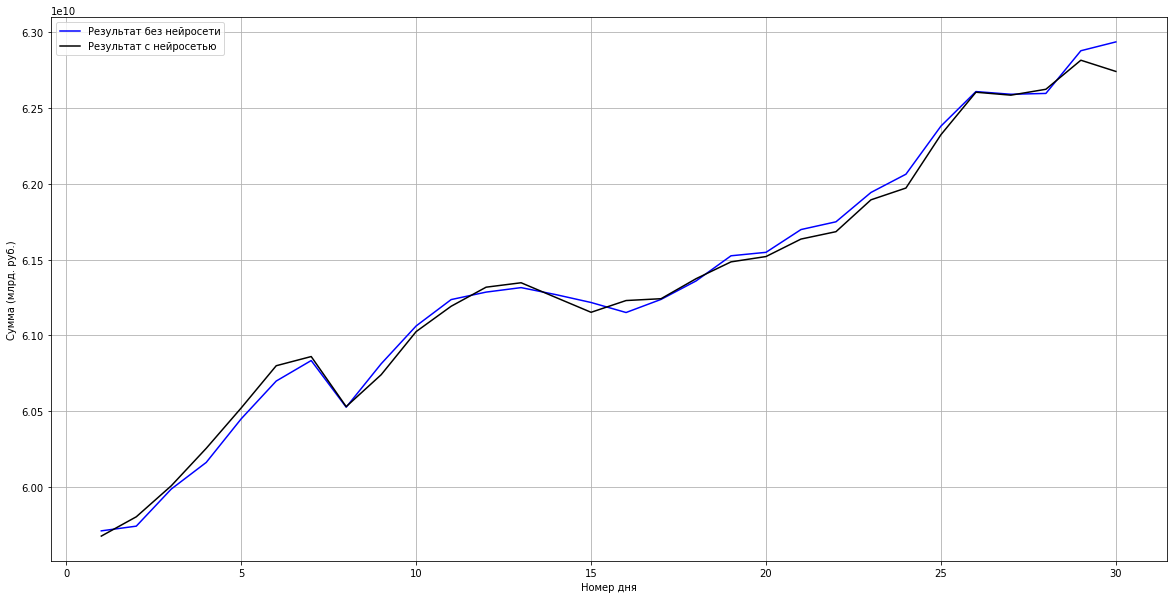

In [110]:
#Строим график
fig, ax = plt.subplots(figsize = (20, 10))
xs = range(1, 31)

ax.plot(xs, Q1, color='blue', linewidth = 1.5, label = 'Результат без нейросети')
ax.plot(xs, Q2, color='black', linewidth = 1.5, label = 'Результат с нейросетью')

ax.grid()
ax.set_ylabel('Сумма (млрд. руб.)')
ax.set_xlabel('Номер дня')    

ax.legend()